In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf 
import os 
import random
from pecnet import Pecnet
from scipy.fft import fft, fftfreq
from scipy.signal import welch
import matplotlib.pyplot as plt
from PyEMD import EMD


# This is for experiment consistency. 
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)
reset_random_seeds(42)

In [2]:
# load data/DailyDelhiClimateTrain.csv
climate_train = pd.read_csv('data/DailyDelhiClimateTrain.csv', parse_dates=True)
climate_test = pd.read_csv('data/DailyDelhiClimateTest.csv', parse_dates=True)
# concatenate train and test
climate = pd.concat([climate_train, climate_test], axis=0)
climate


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [3]:
signal = climate['meantemp'].values

# EXP-1: STANDART VALUES

In [4]:
window_sizes_1 = [1,2,4]
window_sizes_2 = [1,5,10]
window_sizes_3 = [1,10,30]

In [5]:
pecnet = Pecnet(experiment_name="Climate_exp1_1",
                sampling_periods=window_sizes_1,
                sampling_statistics=["mean"],
                sequence_length=4,
                sequence_length_em=4)

X_train, X_test, y_train, y_test = pecnet.preprocess(signal)
pecnet.fit(X_train, y_train)
preds = pecnet.predict(X_test, y_test_past=y_test[:-1])
rmse, r2, mape = pecnet._calculate_scores(preds, y_test[-len(preds):])
print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)

39/39 [==============================] - 0s 330us/step


/Users/hakkoz/opt/anaconda3/envs/serkanTez/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 0s 333us/step
Final train scores: RMSE: 6.575018882751465, R2: 0.20098300922611068, MAPE: 0.2627752721309662
10/10 [==============================] - 0s 391us/step
RMSE:  7.8174
R2:  -0.4361477637358684
MAPE:  0.3168389


In [6]:
pecnet = Pecnet(experiment_name="Climate_exp1_2",
                sampling_periods=window_sizes_2,
                sampling_statistics=["mean"],
                sequence_length=4,
                sequence_length_em=4)

X_train, X_test, y_train, y_test = pecnet.preprocess(signal)
pecnet.fit(X_train, y_train)
preds = pecnet.predict(X_test, y_test_past=y_test[:-1])
rmse, r2, mape = pecnet._calculate_scores(preds, y_test[-len(preds):])
print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)

39/39 [==============================] - 0s 305us/step


/Users/hakkoz/opt/anaconda3/envs/serkanTez/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 0s 377us/step
Final train scores: RMSE: 5.8413567543029785, R2: 0.3562714489790587, MAPE: 0.2233995944261551
10/10 [==============================] - 0s 463us/step
RMSE:  6.9578567
R2:  -0.1581133362354954
MAPE:  0.272699


In [7]:
pecnet = Pecnet(experiment_name="Climate_exp1_3",
                sampling_periods=window_sizes_3,
                sampling_statistics=["mean"],
                sequence_length=4,
                sequence_length_em=4)

X_train, X_test, y_train, y_test = pecnet.preprocess(signal)
pecnet.fit(X_train, y_train)
preds = pecnet.predict(X_test, y_test_past=y_test[:-1])
rmse, r2, mape = pecnet._calculate_scores(preds, y_test[-len(preds):])
print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)

37/37 [==============================] - 0s 338us/step


/Users/hakkoz/opt/anaconda3/envs/serkanTez/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 0s 330us/step
Final train scores: RMSE: 2.2373876571655273, R2: 0.9089710785153446, MAPE: 0.0756688266992569
9/9 [==============================] - 0s 433us/step
RMSE:  2.8386447
R2:  0.8034156238760918
MAPE:  0.09531757


# EXP-2.1: FFT VALUES

In [8]:
def get_fft(signal, fs):
    fourier = np.fft.fft(signal)
    n= len(signal)
    frequencies = np.fft.fftfreq(n, d=1/fs) 
    positive_frequencies = frequencies[np.where(frequencies>0)] 
    magnitudes = abs(fourier[np.where(frequencies >0)])
    return positive_frequencies, magnitudes

3


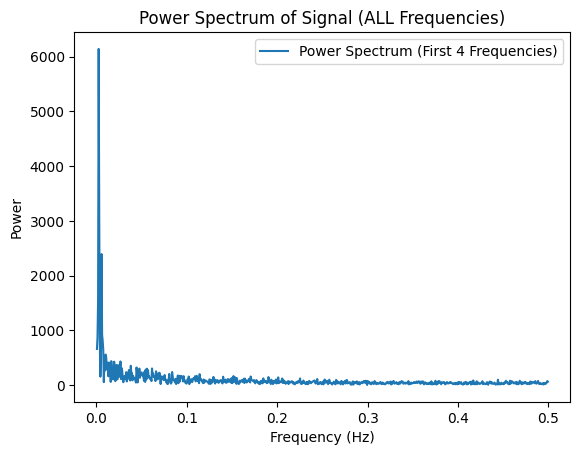

In [9]:
fs = 1

positive_frequencies, magnitudes = get_fft(signal, fs)
peak_frequency = np.argmax(magnitudes)
print(peak_frequency)
plt.plot(positive_frequencies[:1000], magnitudes[:1000], label='Power Spectrum (First 4 Frequencies)')
plt.title('Power Spectrum of Signal (ALL Frequencies)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()

In [10]:
def en_buyuk_uc_indexleri_bul(array):
    if len(array) < 3:
        print("Dizi en az 3 eleman içermelidir.")
        return
    
    sirali_dizi = sorted(enumerate(array), key=lambda x: x[1], reverse=True)
    en_buyuk_uc_indexler = [index for index, value in sirali_dizi[:3]]
    sirali_dizi_indexler = [index for index, value in sirali_dizi]
    
    return en_buyuk_uc_indexler, sirali_dizi_indexler

top_3_idx, sorted_idx = en_buyuk_uc_indexleri_bul(magnitudes)

print("Power spectrumda En büyük üç değerin index'leri:", top_3_idx)
for idx in top_3_idx:
    print("En büyük üç değerin frekansları:", positive_frequencies[idx])
    print("En büyük üç değerin windowları:", (round(1 / (positive_frequencies[idx]))))

Power spectrumda En büyük üç değerin index'leri: [3, 4, 8]
En büyük üç değerin frekansları: 0.0025380710659898475
En büyük üç değerin windowları: 394
En büyük üç değerin frekansları: 0.0031725888324873096
En büyük üç değerin windowları: 315
En büyük üç değerin frekansları: 0.005710659898477157
En büyük üç değerin windowları: 175


In [11]:
def select_meaningful_periods(positive_frequencies, sorted_idx):
    top_freqs = [positive_frequencies[idx] for idx in sorted_idx]
    top_periods = [round(1 / freq) for freq in top_freqs]
    # select periods that are less than 0.1% of the signal length
    top_periods_eliminated = [period for period in top_periods if period < len(signal)*0.01]
    # remove reduntant periods without losing order
    top_periods_final = []
    for period in top_periods_eliminated:
        if period not in top_periods_final:
            top_periods_final.append(period)
    return top_periods_final

In [12]:
periods = select_meaningful_periods(positive_frequencies, sorted_idx)
periods[:2]

[15, 12]

In [13]:
window_length_fft = [1,12,15]

In [14]:
pecnet = Pecnet(experiment_name="Climate_exp2_1",
                sampling_periods=window_length_fft,
                sampling_statistics=["mean"],
                sequence_length=4,
                sequence_length_em=4)

X_train, X_test, y_train, y_test = pecnet.preprocess(signal)
pecnet.fit(X_train, y_train)
preds = pecnet.predict(X_test, y_test_past=y_test[:-1])
rmse, r2, mape = pecnet._calculate_scores(preds, y_test[-len(preds):])
print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)

38/38 [==============================] - 0s 338us/step


/Users/hakkoz/opt/anaconda3/envs/serkanTez/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 0s 334us/step
Final train scores: RMSE: 4.2052998542785645, R2: 0.6659504142874483, MAPE: 0.14695943892002106
10/10 [==============================] - 0s 395us/step
RMSE:  4.888616
R2:  0.42072421480341415
MAPE:  0.1895095


# EXP-2.2: WELCH VALUES

0


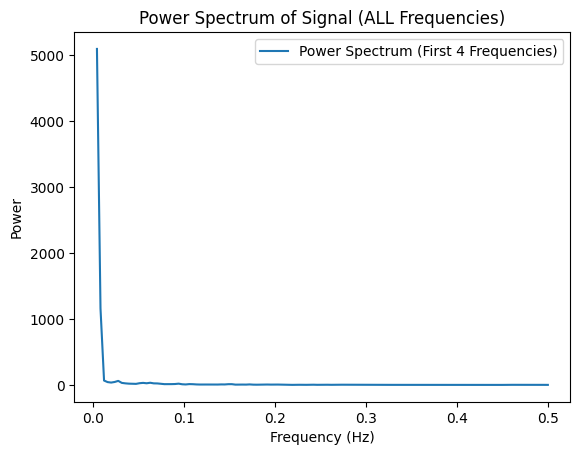

In [15]:
# https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/

def get_psd_values(y_values, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    # return only positive frequencies and respective PSD values
    positive_frequencies = f_values[np.where(f_values>0)]
    positive_psd = psd_values[np.where(f_values>0)]
    return positive_frequencies, positive_psd

positive_frequencies, magnitudes = get_psd_values(signal, fs)
peak_frequency = np.argmax(magnitudes)
print(peak_frequency)
plt.plot(positive_frequencies[:1000], magnitudes[:1000], label='Power Spectrum (First 4 Frequencies)')
plt.title('Power Spectrum of Signal (ALL Frequencies)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()

In [16]:
top_3_idx, sorted_idx = en_buyuk_uc_indexleri_bul(magnitudes)

print("Power spectrumda En büyük üç değerin index'leri:", top_3_idx)
for idx in top_3_idx:
    print("En büyük üç değerin frekansları:", positive_frequencies[idx])
    print("En büyük üç değerin windowları:", (round(1 / (positive_frequencies[idx]))))

Power spectrumda En büyük üç değerin index'leri: [0, 1, 2]
En büyük üç değerin frekansları: 0.00390625
En büyük üç değerin windowları: 256
En büyük üç değerin frekansları: 0.0078125
En büyük üç değerin windowları: 128
En büyük üç değerin frekansları: 0.01171875
En büyük üç değerin windowları: 85


In [17]:
periods = select_meaningful_periods(positive_frequencies, sorted_idx)
periods[:2]

[15, 14]

In [18]:
window_length_welch = [1,14,15]

In [19]:
pecnet = Pecnet(experiment_name="Climate_exp2_2",
                sampling_periods=window_length_welch,
                sampling_statistics=["mean"],
                sequence_length=4,
                sequence_length_em=4)

X_train, X_test, y_train, y_test = pecnet.preprocess(signal)
pecnet.fit(X_train, y_train)
preds = pecnet.predict(X_test, y_test_past=y_test[:-1])
rmse, r2, mape = pecnet._calculate_scores(preds, y_test[-len(preds):])
print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)

38/38 [==============================] - 0s 346us/step


/Users/hakkoz/opt/anaconda3/envs/serkanTez/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 0s 333us/step
Final train scores: RMSE: 4.13960075378418, R2: 0.676306513237217, MAPE: 0.14465223252773285
10/10 [==============================] - 0s 402us/step
RMSE:  5.140623
R2:  0.3594617833444397
MAPE:  0.19963256


# EXP-3.1: EMD + FFT

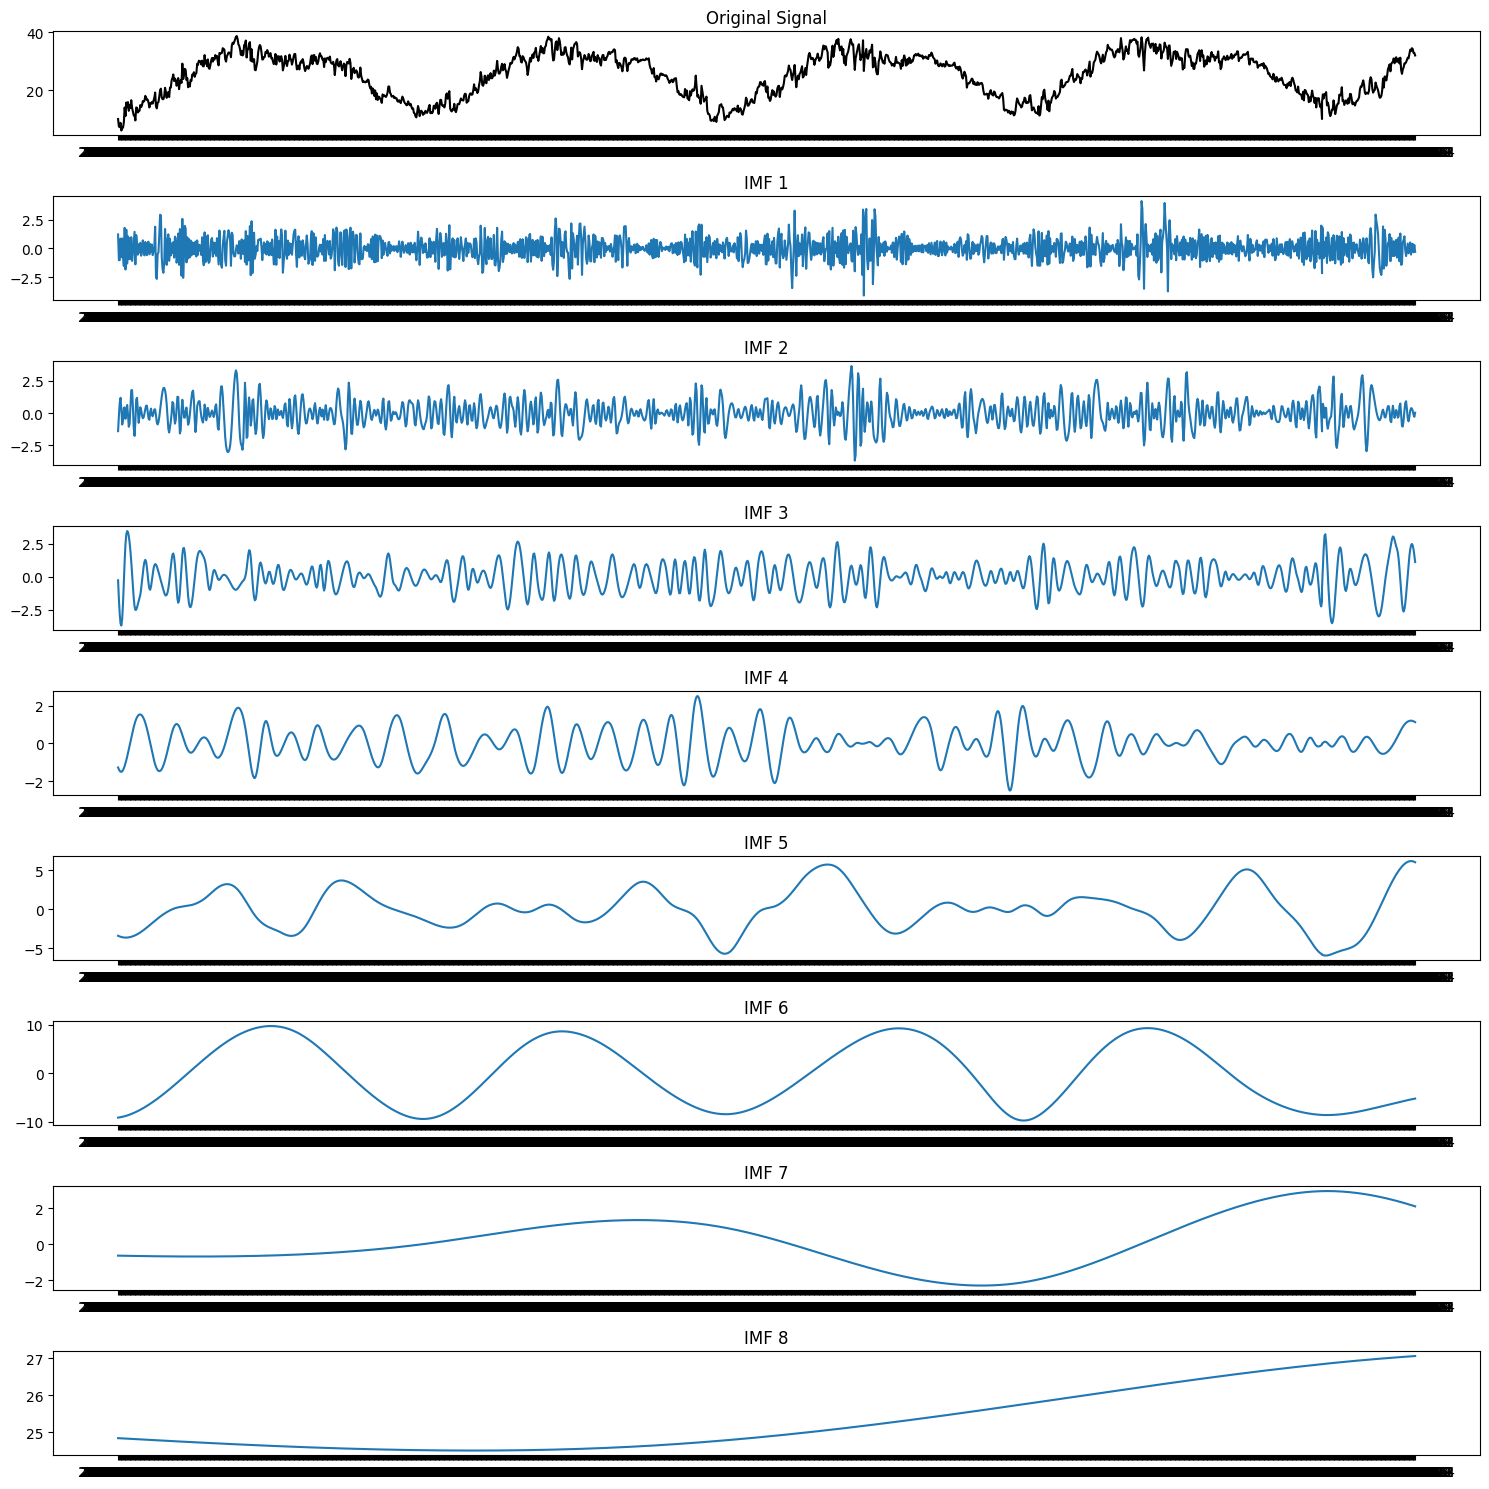

In [20]:
# Apply Empirical Mode Decomposition (EMD)
emd = EMD()
IMFs = emd(signal)


# Plot the original signal and its IMFs
plt.figure(figsize=(15, 15))

plt.subplot(len(IMFs) + 1, 1, 1)
plt.plot(climate.date, signal, label='Original Signal', color='black')
plt.title('Original Signal')

for i in range(len(IMFs)):
    plt.subplot(len(IMFs) + 1, 1, i + 2)
    plt.plot(climate.date, IMFs[i], label=f'IMF {i + 1}')
    plt.title(f'IMF {i + 1}')

plt.tight_layout()
plt.show()

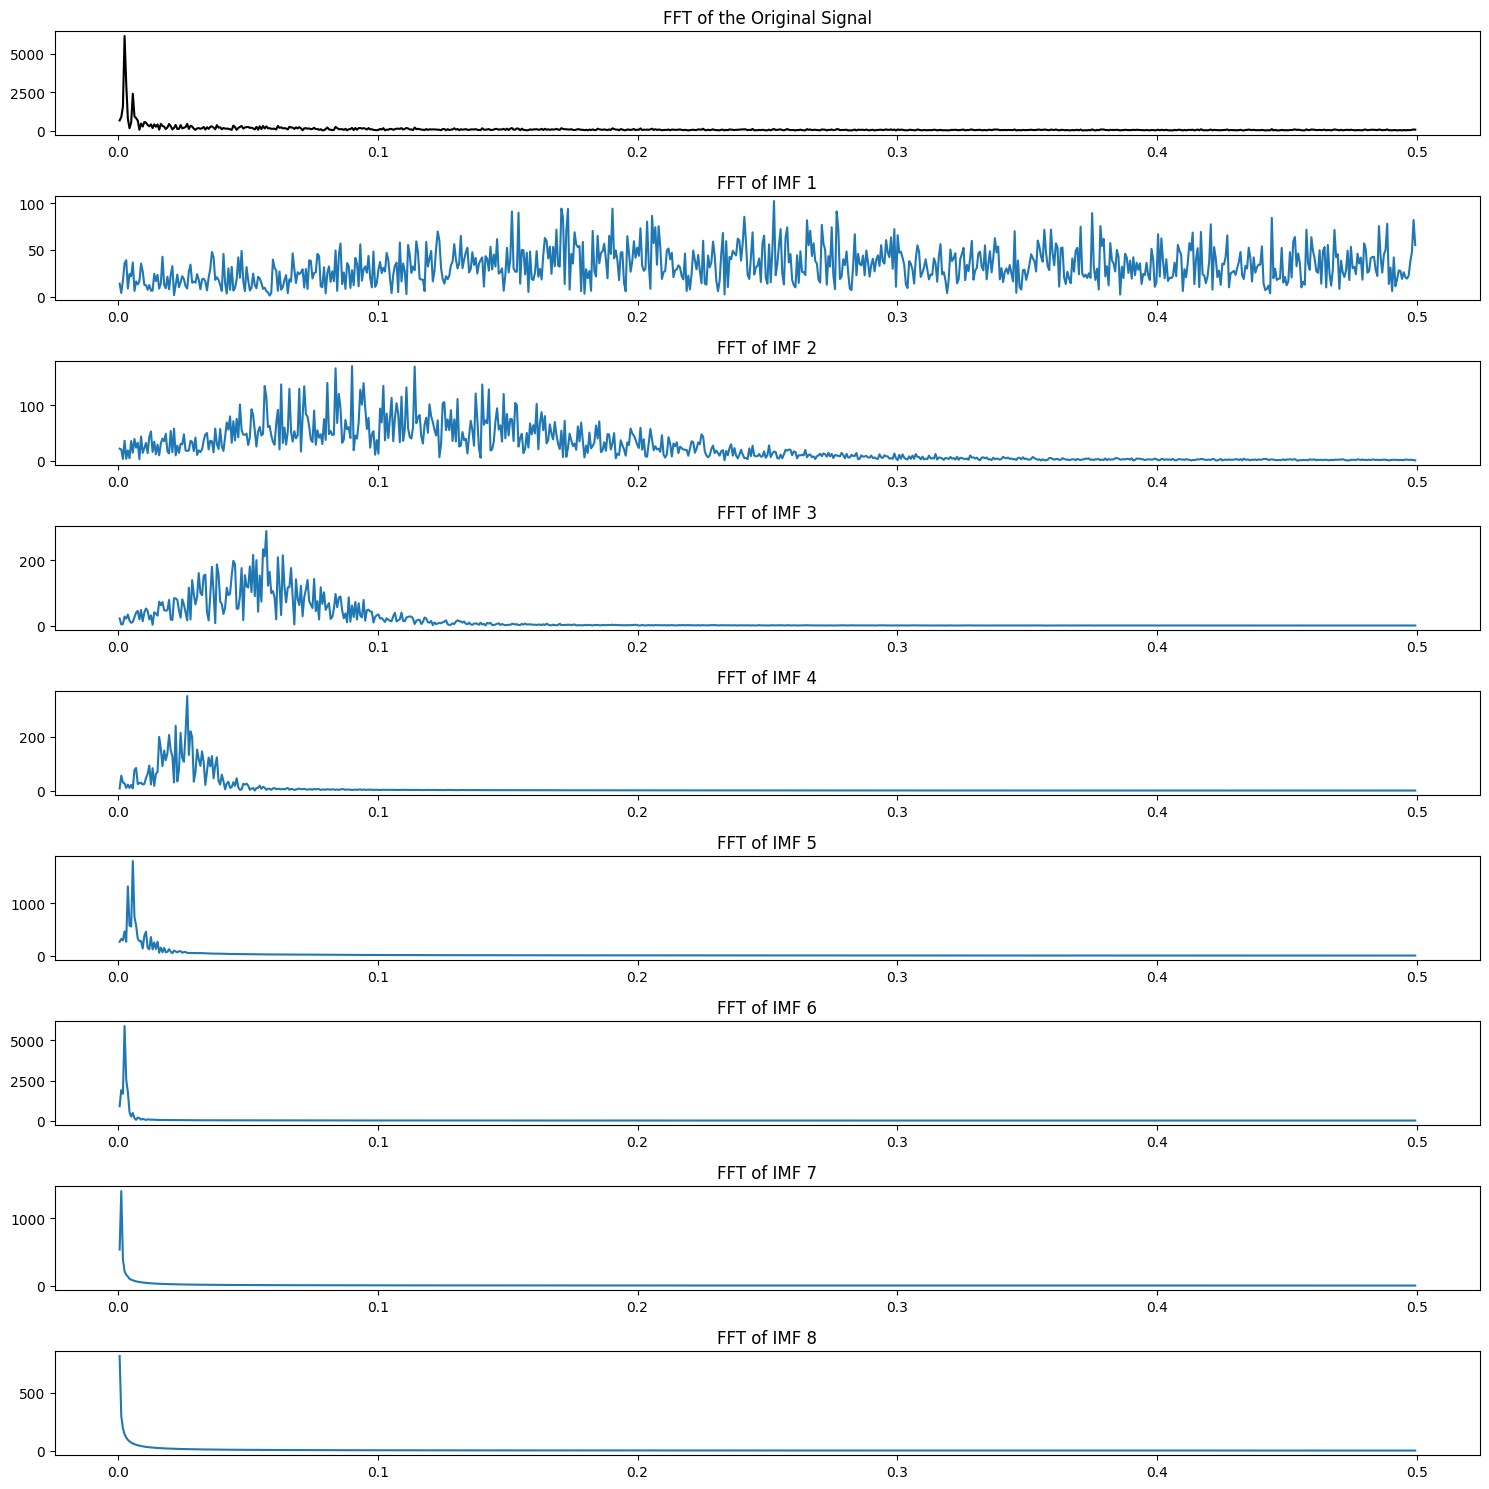

In [21]:
fs =  1

# Plot the original signal and its IMFs
plt.figure(figsize=(15, 15))

plt.subplot(len(IMFs) + 1, 1, 1)
positive_frequencies, magnitudes = get_fft(signal, fs)
plt.plot(positive_frequencies, magnitudes, label='Original Signal', color='black')
plt.title('FFT of the Original Signal')

for i in range(len(IMFs)):
    plt.subplot(len(IMFs) + 1, 1, i + 2)
    positive_frequencies, magnitudes = get_fft(IMFs[i], fs)
    plt.plot(positive_frequencies, magnitudes, label=f'IMF {i + 1}')
    plt.title(f'FFT of IMF {i + 1}')

plt.tight_layout()
plt.show()

In [22]:
# Calculate sampling frequency
periods=[]
days=len(signal)
for i, imf in enumerate(IMFs):
    freq, magnitudes = get_fft(imf, fs)
    idx=np.argmax(magnitudes)
    print("IMF idx: ", i)
    print("Dominant freq idx: ", idx)
    print("Window size: ",round(1/freq[idx]))
    print("\n")
    periods.append(round(1/freq[idx]))


IMF idx:  0
Dominant freq idx:  397
Window size:  4


IMF idx:  1
Dominant freq idx:  141
Window size:  11


IMF idx:  2
Dominant freq idx:  89
Window size:  18


IMF idx:  3
Dominant freq idx:  41
Window size:  38


IMF idx:  4
Dominant freq idx:  8
Window size:  175


IMF idx:  5
Dominant freq idx:  3
Window size:  394


IMF idx:  6
Dominant freq idx:  1
Window size:  788


IMF idx:  7
Dominant freq idx:  0
Window size:  1576




In [23]:
periods[:2]

[4, 11]

In [24]:
window_length_emd_fft = [1, 4, 11]

In [25]:
pecnet = Pecnet(experiment_name="Climate_exp3_1",
                sampling_periods=window_length_emd_fft,
                sampling_statistics=["mean"],
                sequence_length=4,
                sequence_length_em=4)

X_train, X_test, y_train, y_test = pecnet.preprocess(signal)
pecnet.fit(X_train, y_train)
preds = pecnet.predict(X_test, y_test_past=y_test[:-1])
rmse, r2, mape = pecnet._calculate_scores(preds, y_test[-len(preds):])
print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)

39/39 [==============================] - 0s 347us/step


/Users/hakkoz/opt/anaconda3/envs/serkanTez/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 0s 360us/step
Final train scores: RMSE: 5.658131122589111, R2: 0.39416447197199933, MAPE: 0.21050995588302612
10/10 [==============================] - 0s 508us/step
RMSE:  5.4126883
R2:  0.2967893846028432
MAPE:  0.20596653


# EXP-3.2: EMD + WELCH

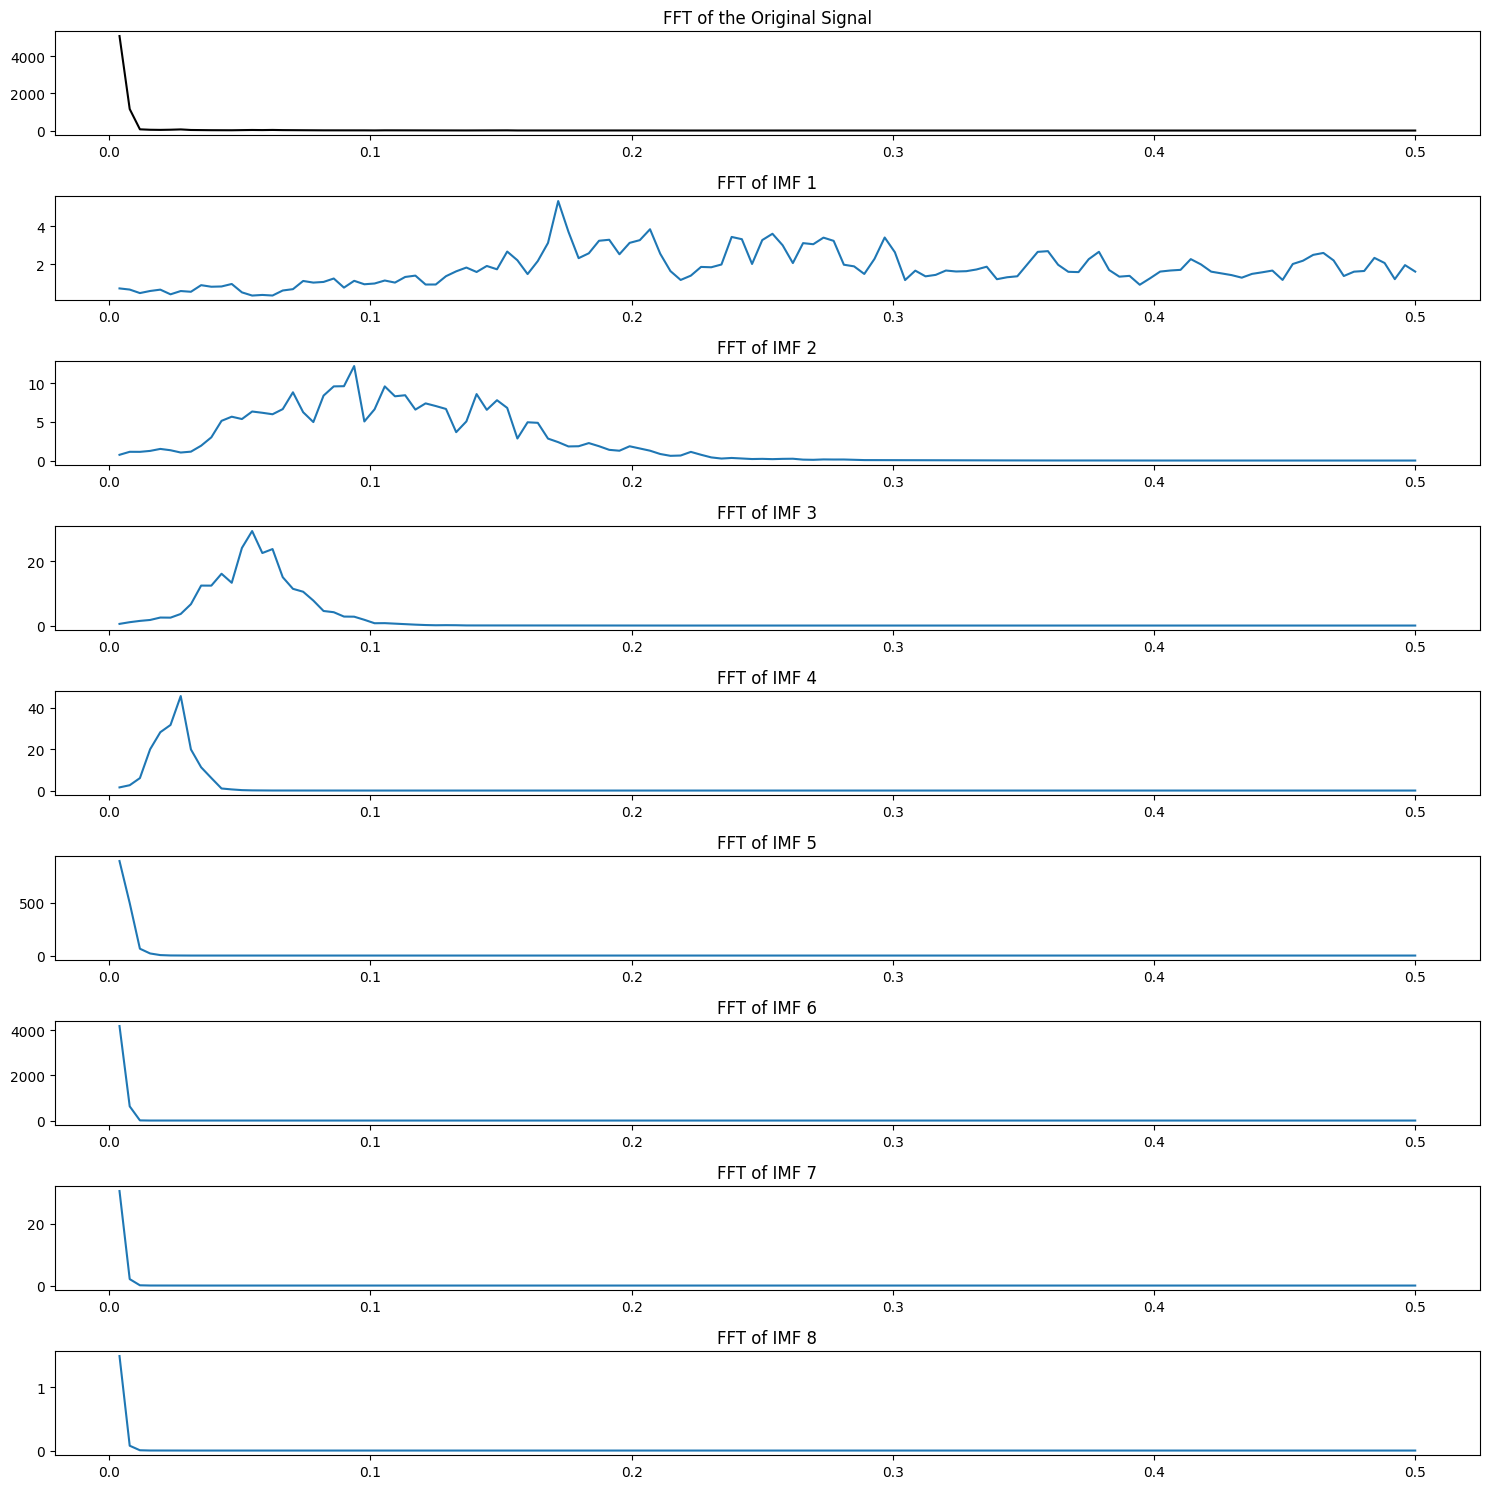

In [26]:
fs =  1

# Plot the original signal and its IMFs
plt.figure(figsize=(15, 15))

plt.subplot(len(IMFs) + 1, 1, 1)
positive_frequencies, magnitudes = get_psd_values(signal, fs)
plt.plot(positive_frequencies, magnitudes, label='Original Signal', color='black')
plt.title('FFT of the Original Signal')

for i in range(len(IMFs)):
    plt.subplot(len(IMFs) + 1, 1, i + 2)
    positive_frequencies, magnitudes = get_psd_values(IMFs[i], fs)
    plt.plot(positive_frequencies, magnitudes, label=f'IMF {i + 1}')
    plt.title(f'FFT of IMF {i + 1}')

plt.tight_layout()
plt.show()

In [27]:
# Calculate sampling frequency
periods=[]
days=len(signal)
for i, imf in enumerate(IMFs):
    freq, magnitudes = get_fft(imf, fs)
    idx=np.argmax(magnitudes)
    print("IMF idx: ", i)
    print("Dominant freq idx: ", idx)
    print("Window size: ",round(1/freq[idx]))
    print("\n")
    periods.append(round(1/freq[idx]))

IMF idx:  0
Dominant freq idx:  397
Window size:  4


IMF idx:  1
Dominant freq idx:  141
Window size:  11


IMF idx:  2
Dominant freq idx:  89
Window size:  18


IMF idx:  3
Dominant freq idx:  41
Window size:  38


IMF idx:  4
Dominant freq idx:  8
Window size:  175


IMF idx:  5
Dominant freq idx:  3
Window size:  394


IMF idx:  6
Dominant freq idx:  1
Window size:  788


IMF idx:  7
Dominant freq idx:  0
Window size:  1576




In [28]:
periods[:2]

[4, 11]

In [29]:
window_length_emd_welch = [1, 4, 11]

In [30]:
pecnet = Pecnet(experiment_name="IBM_exp3_2",
                sampling_periods=window_length_emd_welch,
                sampling_statistics=["mean"],
                sequence_length=4,
                sequence_length_em=4,
                wavelet="sym2")

X_train, X_test, y_train, y_test = pecnet.preprocess(signal)
pecnet.fit(X_train, y_train)
preds = pecnet.predict(X_test, y_test_past=y_test[:-1])
rmse, r2, mape = pecnet._calculate_scores(preds, y_test[-len(preds):])
print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)

39/39 [==============================] - 0s 340us/step


/Users/hakkoz/opt/anaconda3/envs/serkanTez/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 0s 365us/step
Final train scores: RMSE: 5.688313007354736, R2: 0.3876839255395802, MAPE: 0.21340440213680267
10/10 [==============================] - 0s 402us/step
RMSE:  6.596613
R2:  -0.04448303388824093
MAPE:  0.2594344


RMSE:  6.596613
R2:  -0.04448303388824093
MAPE:  0.2594344